In [1]:
from django.conf import settings
settings.configure(BASE_DIR='/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska/djangoapp',)

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import sys
sys.path.append('/Users/adammajczyk/Documents/AAA_Semy/Sem7/inzynierka/pracaInzynierska') 

In [2]:
from djangoapp.news.scripts.llm import *
from djangoapp.news.scripts.model_loader2 import *
from djangoapp.news.scripts.nlp import *

In [3]:
import pandas as pd
import pickle  
from tqdm.notebook import tqdm 

In [4]:
model_loader = ModelLoader()
llm = model_loader.llm 
vertex = model_loader.vertex
summarizer = model_loader.summarizer

## Testing Local LLM

In [30]:
df_test = pd.DataFrame() 
df_val2 = pd.DataFrame()

In [96]:
datasets_llm = dict()
for name in ['df_test', 'df_val2']:
    datasets_llm[name] = pd.DataFrame()

for dataset_name in datasets_llm.keys():
    # extract suffix after _
    dataset_name_suff = dataset_name.split('_')[1]
    file_name = f'llm_results_{dataset_name_suff}.csv'
    # check if file exists
    if os.path.isfile(file_name):
        print(f'Loading {file_name}...')
        datasets_llm[dataset_name] = pd.read_csv(file_name)
    else:
        datasets_llm[dataset_name] = df[df['sample'] == dataset_name_suff].reset_index(drop=True)

Loading llm_results_test.csv...
Loading llm_results_val2.csv...


In [97]:
import copy as cp
for dataset_name in datasets_llm.keys():
    if 'llm_pred' in datasets_llm[dataset_name].columns:
        print(f'{dataset_name} already predicted')
        continue
    print(f'Predicting {dataset_name}...')
    for i, row in tqdm(datasets_llm[dataset_name].iterrows(), total=datasets_llm[dataset_name].shape[0]):
        if row['title'] is not None:
            datasets_llm[dataset_name].loc[i, 'llm_pred'] = llm.predict(row['title'])
        else:
            datasets_llm[dataset_name].loc[i, 'llm_pred'] = None



df_test already predicted
df_val2 already predicted


In [98]:
for dataset_name in datasets_llm.keys():
    # extract suffix after _
    dataset = cp.deepcopy(datasets_llm[dataset_name])
    print(dataset.columns)
    dataset_name_suff = dataset_name.split('_')[1]
    file_name = f'llm_results_{dataset_name_suff}.csv'
    dataset[['title', 'is_clickbait', 'dataset', 'sample', 'llm_pred']].to_csv(file_name, index=False)
    print(f'Saved {file_name}...')

Index(['title', 'is_clickbait', 'dataset', 'sample', 'llm_pred'], dtype='object')
Saved llm_results_test.csv...
Index(['title', 'is_clickbait', 'dataset', 'sample', 'llm_pred'], dtype='object')
Saved llm_results_val2.csv...


In [99]:
df_test = datasets_llm['df_test']
df_val2 = datasets_llm['df_val2']
df_test.shape, df_val2.shape

((2590, 5), (1296, 5))

In [100]:
y_true = df_test['is_clickbait'].values
y_pred_proba = df_test['llm_pred'].values
y_pred = (y_pred_proba > 0.5).astype(int)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

print(f'F1: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):>9.4f}')



F1:          0.8193
ROC AUC:     0.9672
Recall:      0.7010
Precision:   0.9856
Accuracy:    0.8483


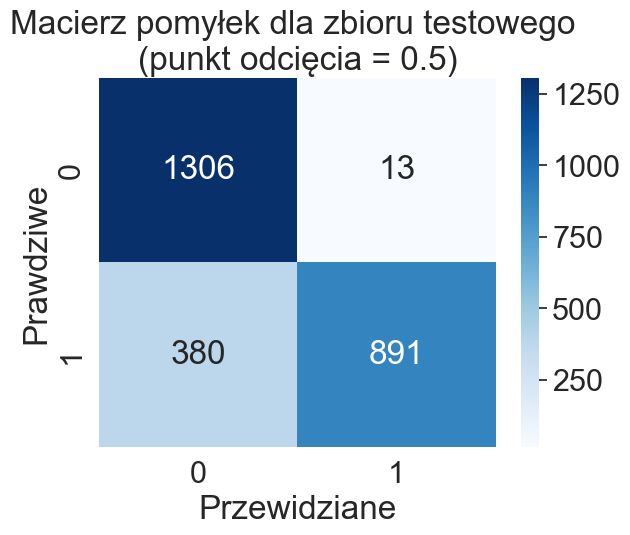

In [101]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
sns.set(font_scale=2)
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek dla zbioru testowego \n(punkt odcięcia = 0.5)')
plt.show()

In [102]:
# find optimal threshold for F1 score
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

y_true_val = df_val2['is_clickbait'].values
y_pred_proba_val = df_val2['llm_pred'].values
n = 10000
thresholds = []
for i in tqdm(range(n)):
    threshold = i/n
    y_pred = (y_pred_proba_val > threshold).astype(int)
    thresholds.append((threshold, f1_score(y_true_val, y_pred)))
thresholds.sort(key=lambda x: x[1], reverse=True)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [103]:
print(thresholds[:1][0][0])

0.0031


In [104]:
y_pred = (y_pred_proba > thresholds[:1][0][0]).astype(int)

from sklearn.metrics import roc_auc_score, f1_score
print(f'F1 best F1 thresh: {f1_score(y_true, y_pred):>15.4f}')
print(f'ROC AUC best F1 thresh: {roc_auc_score(y_true, y_pred_proba):>10.4f}')
print(f'Recall best F1 thresh: {recall_score(y_true, y_pred):>11.4f}')
print(f'Precision best F1 thresh: {precision_score(y_true, y_pred):>8.4f}')
print(f'Accuracy best F1 thresh: {accuracy_score(y_true, y_pred):>9.4f}')




F1 best F1 thresh:          0.9024
ROC AUC best F1 thresh:     0.9672
Recall best F1 thresh:      0.8914
Precision best F1 thresh:   0.9137
Accuracy best F1 thresh:    0.9054


In [105]:
threshold = thresholds[:1][0][0]

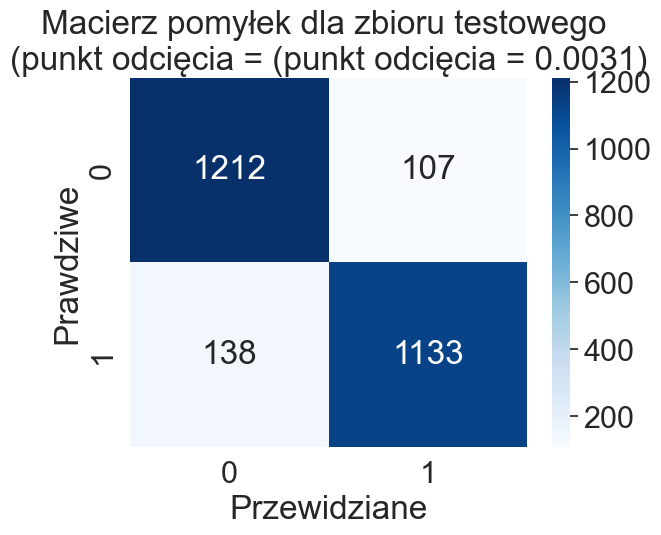

In [106]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels to heatmap
sns.set(font_scale=2)
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek dla zbioru testowego \n(punkt odcięcia = (punkt odcięcia = {:.4f})'.format(threshold))
plt.show()

In [107]:
df = cp.deepcopy(df_test)

In [108]:
df=df[df['sample']=='test'].reset_index(drop=True)
df

,title,is_clickbait,dataset,sample,llm_pred
0,Florida Backs Away From Prep Schedule Favoring...,0,clickbait-dataset,test,0.000536
1,BECK: COMEY LETTER ‘ONE OF THE MOST IRRESPONSI...,1,fake-news,test,0.962702
2,"Sydney’s Swelter Has a Climate Change Link, Sc...",0,fake-news,test,0.000254
3,"California Today: Airbnb, a Hometown Success (...",0,fake-news,test,0.000607
4,Clinton Could Win Because She Controls the Vot...,1,fake-news,test,0.155982
...,...,...,...,...,...
2585,Carlson: Trump-Russia ’Hoax’ an Effort to Topp...,0,fake-news,test,0.000531
2586,Airplane crashes in Nigeria,0,clickbait-dataset,test,0.000091
2587,"Si no se prohíbe la tauromaquia, en 2020 dos d...",1,fake-news,test,0.001254
2588,"Clinton, FBIGate and the true depth of the Oba...",1,fake-news,test,0.011797


In [109]:
dataset_combinations = ['data_all_datasets', 'data_fake-news', 'data_clickbait-dataset']
metrics = ['accuracy', 'precision', 'recall', 'f1-score', 'roc-auc']
tresholds = ['defaultThresh', 'optimizedF1Thresh']

In [110]:
import copy as cp
df_all_datasets = cp.deepcopy(df)
df_clickbait_dataset = df[df['dataset']=='clickbait-dataset'].reset_index(drop=True)
df_fake_news = df[df['dataset']=='fake-news'].reset_index(drop=True)

In [111]:
results = dict()


for dataset in dataset_combinations:
    results[dataset] = dict()
    for threshold in tresholds:
        results[dataset][threshold] = dict()
        for metric in metrics:
            results[dataset][threshold][metric] = None


In [115]:
opt_threshold = thresholds[:1][0][0]
opt_threshold

0.0031

In [116]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


for dataset in tqdm(dataset_combinations, desc='datasets'):
    if dataset == 'data_all_datasets':
        df_temp = cp.deepcopy(df_all_datasets)
        dataset_name = 'all_datasets'
    elif dataset == 'data_fake-news':
        df_temp = cp.deepcopy(df_fake_news)
        dataset_name = 'fake-news'
    elif dataset == 'data_clickbait-dataset':
        df_temp = cp.deepcopy(df_clickbait_dataset)
        dataset_name = 'clickbait-dataset'

    for threhold, threshold_name in zip([0.5, opt_threshold], ['defaultThresh', 'optimizedF1Thresh']):
    

        y_true = df_temp['is_clickbait'].values
        y_pred_proba = df_temp['llm_pred'].values
        y_pred = (y_pred_proba > threhold).astype(int)


        results[dataset][threshold_name]['accuracy'] = accuracy_score(y_true, y_pred)
        results[dataset][threshold_name]['precision'] = precision_score(y_true, y_pred)
        results[dataset][threshold_name]['recall'] = recall_score(y_true, y_pred)
        results[dataset][threshold_name]['f1-score'] = f1_score(y_true, y_pred)
        results[dataset][threshold_name]['roc-auc'] = roc_auc_score(y_true, y_pred_proba)



    


datasets:   0%|          | 0/3 [00:00<?, ?it/s]

In [117]:
# unpack the results to a dataframe
results_list = []
results_df = pd.DataFrame()

for dataset in dataset_combinations:
    for threshold in tresholds:
        for metric in metrics:
            results_list.append([ dataset, threshold, metric, results[dataset][threshold][metric]])

results_df = pd.DataFrame(results_list, columns=[ 'dataset', 'threshold', 'metric', 'value'])
results_df.head()

,dataset,threshold,metric,value
0,data_all_datasets,defaultThresh,accuracy,0.848263
1,data_all_datasets,defaultThresh,precision,0.985619
2,data_all_datasets,defaultThresh,recall,0.701023
3,data_all_datasets,defaultThresh,f1-score,0.819310
4,data_all_datasets,defaultThresh,roc-auc,0.967212


In [118]:
res = results_df

In [119]:
res_pivot = res.pivot_table(index=['dataset'], columns=['threshold', 'metric'], values='value', aggfunc='mean').reset_index()
res_pivot = res_pivot.transpose()

res_pivot


0                       1  \
threshold         metric                                                 
dataset                      data_all_datasets  data_clickbait-dataset   
defaultThresh     accuracy            0.848263                0.996238   
                  f1-score             0.81931                0.996231   
                  precision           0.985619                0.996231   
                  recall              0.701023                0.996231   
                  roc-auc             0.967212                0.999816   
optimizedF1Thresh accuracy            0.905405                0.968025   
                  f1-score            0.902429                0.968921   
                  precision            0.91371                0.940828   
                  recall              0.891424                0.998744   
                  roc-auc             0.967212                0.999816   

                                          2  
threshold         metric                     
dataset                      data_fake-news  
defaultThresh     accuracy         0.611055  
                  f1-score         0.336192  
                  precision        0.907407  
                  recall           0.206316  
                  roc-auc          0.896838  
optimizedF1Thresh accuracy         0.805025  
                  f1-score         0.777011  
                  precision        0.855696  
                  recall           0.711579  
                  roc-auc          0.896838